In [39]:
import uproot
import numpy as np
import scipy
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm
import pandas as pd
import math
from scipy import stats
import os
import random
from numba import jit, njit, vectorize, cuda
from scipy.spatial.distance import cdist

## IFT Data

In [40]:
IFT = uproot.open("../../FASER-Track-Matching/IFT/trackerspfit.root")
IFT['spfit'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
evtId                | int32_t                  | AsDtype('>i4')
sp_track_x           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
sp_track_y           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
sp_track_z           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
sp_track_x_err       | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
sp_track_y_err       | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
sp_track_z_err       | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
sp_track_x_predicted | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
sp_track_y_predicted | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
sp_track_z_predicted | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
sp_track_x_residual  | std::vector<double>  

In [41]:
# As awkward arrays
tree = IFT['spfit']
ift = tree.arrays(['sp_track_x',
                   'sp_track_y',
                   'sp_track_z',
                   'sp_track_x_err',
                   'sp_track_y_err',
                   'sp_track_z_err',
                   'sp_track_x_predicted',
                   'sp_track_y_predicted',
                   'sp_track_z_predicted',
                   'sp_track_x_residual',
                   'sp_track_y_residual',
                   'sp_track_z_residual',
                   'track_p1',                  # tx
                   'track_p3'], library='ak')   # ty

def DefineIFT(data, status=''):
    if status =='first': # first layer
        position = ak.where(ak.num(data)==3)
        result = ak.firsts(data[position])  
    elif status == 'second': # second layer
        result = ak.mask(data, ak.num(data)==3)[:, 1]
        result = result[~ak.is_none(result)]
    elif status == 'third': # third layer
        result = ak.mask(data, ak.num(data)==3)[:, -1]
        result = result[~ak.is_none(result)]
    else:
        print('missing element')
    return result

def ConvertPanda(data, status):
    dict = {"x": DefineIFT(ift['sp_track_x'], status=status), "y":DefineIFT(ift['sp_track_y'], status=status), "z":DefineIFT(ift['sp_track_z'], status=status),
            'x error':DefineIFT(ift['sp_track_x_err'], status=status), 'y error':DefineIFT(ift['sp_track_y_err'], status=status), 
            "tx":DefineIFT(ift['track_p1'], status=status), "ty":DefineIFT(ift['track_p3'], status=status)}
    return pd.DataFrame(dict)

ift_first_layer = ConvertPanda(ift, 'first')
ift_second_layer = ConvertPanda(ift, 'second')
ift_third_layer = ConvertPanda(ift, 'third')


In [42]:
print(f"Minimum tx value on IFT: {ak.min(ift['track_p1'])}, \
        Maximum tx value on IFT: {ak.max(ift['track_p1'])}, \
        Minimum ty value on IFT: {ak.min(ift['track_p3'])}, \
        Maximum ty value on IFT: {ak.max(ift['track_p3'])}")

Minimum tx value on IFT: -2.5210052823349,         Maximum tx value on IFT: 2.5711560381889433,         Minimum ty value on IFT: -1.2409342951460778,         Maximum ty value on IFT: 1.7713590005245758


## Emulsion Data

In [43]:
# pre-process using PANDAS
area1_1 = pd.read_csv("../Emulsion Data/chk_trks_area1-1_20220203.txt", sep='\s+', header=None)
area1_2 = pd.read_csv("../Emulsion Data/chk_trks_area1-2_20220203.txt", sep='\s+', header=None)
area1_3 = pd.read_csv("../Emulsion Data/chk_trks_area1-3_20220203.txt", sep='\s+', header=None)
area1_4 = pd.read_csv("../Emulsion Data/chk_trks_area1-4_20220203.txt", sep='\s+', header=None)

combine = area1_1.append(area1_2, ignore_index=True)
combine = combine.append(area1_3, ignore_index=True)

emulsion = combine.append(area1_4, ignore_index=True)
emulsion.columns = ["t->ID", "plate_first", "plate_last", "x", "y", "z_last", 
                    "tx", "ty", "tx_pos", "ty_pos", "t->N()", "t->Npl()"]

# only keeping tracks that end on plate 20, the plate closest to the IFT
emulsion_20 = emulsion[emulsion["plate_last"] == 20]

### Applying Cuts on ty

In [44]:
def Filter(data, ty_lower_cut, ty_upper_cut=0, upper=False):
    mean = np.mean(data['ty'])
    filter1 = data[data['ty'] > (mean + ty_lower_cut)]
    filter2 = data[data['ty'] < (mean - ty_lower_cut)]
    filter12 = pd.concat([filter1, filter2])
    filter = filter12
    if upper:
        filter3 = filter[filter['ty'] > (mean - ty_upper_cut)]
        filter4 = filter3[filter3['ty'] < (mean + ty_upper_cut)]
        filter = filter4
    print(f'{len(filter)/len(data)*100}% data is selected after cut')
    return filter

ift_filter1 = Filter(ift_first_layer, ty_lower_cut=0.05, ty_upper_cut=0.1, upper=True)
ift_filter2 = Filter(ift_second_layer, ty_lower_cut=0.05, ty_upper_cut=0.1, upper=True)
ift_filter3 = Filter(ift_third_layer, ty_lower_cut=0.05, ty_upper_cut=0.1, upper=True)

2.19664167282712% data is selected after cut
2.19664167282712% data is selected after cut
2.19664167282712% data is selected after cut


### Vector Field Function (for track matching)

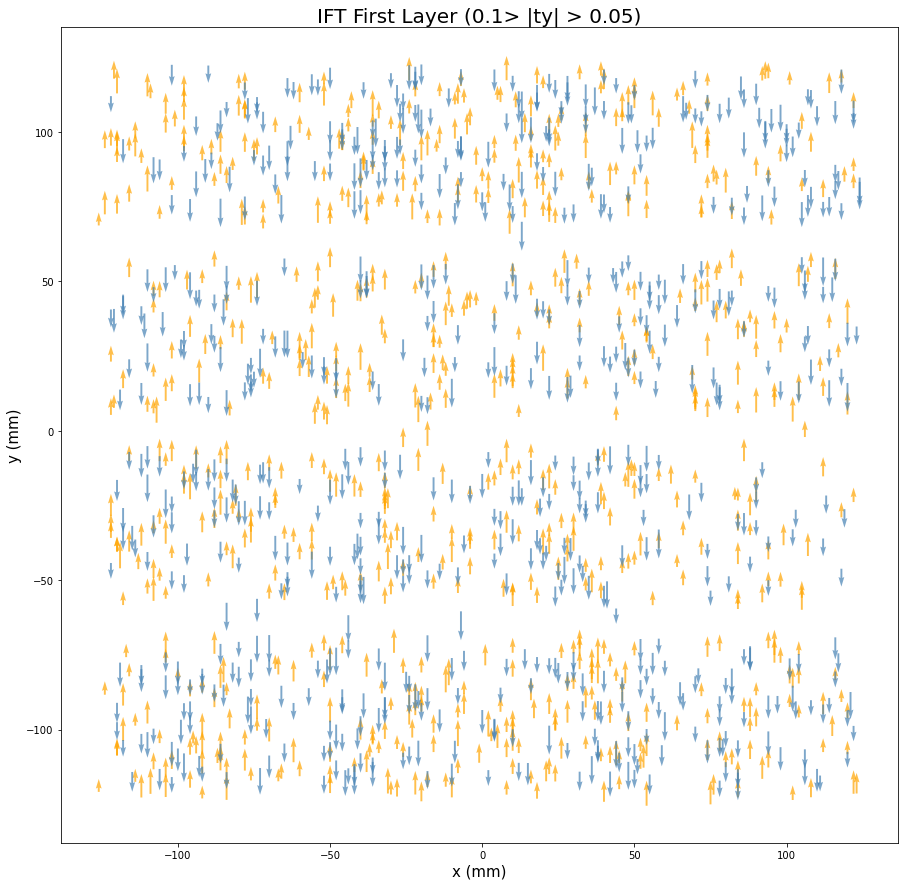

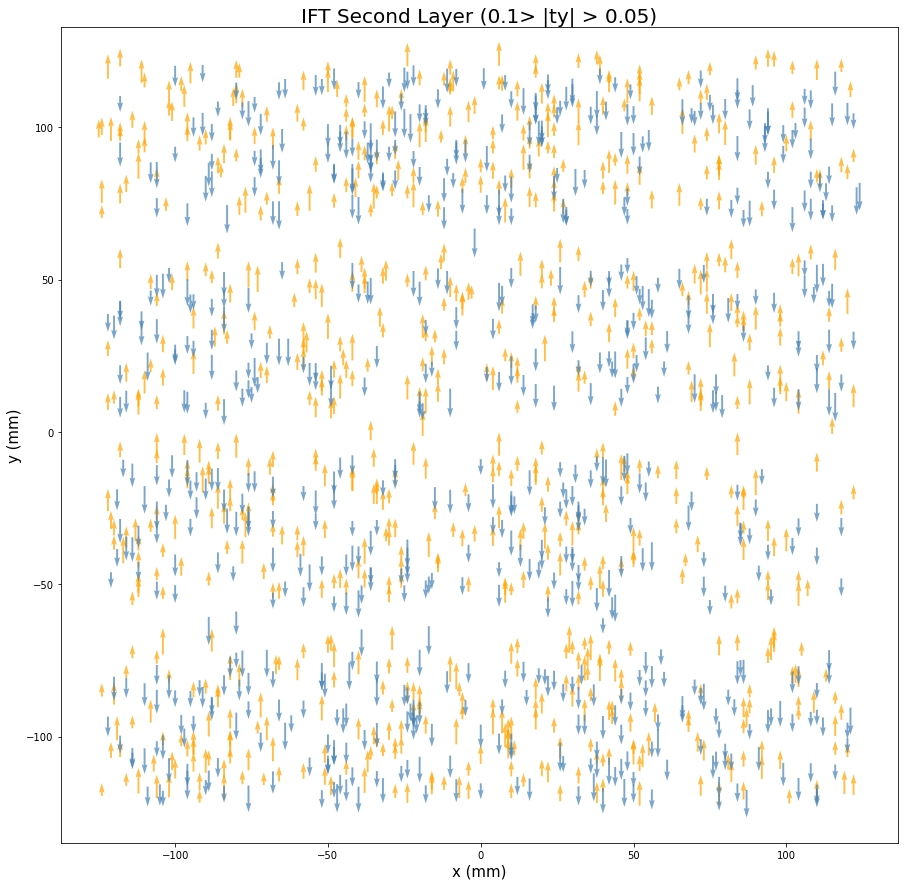

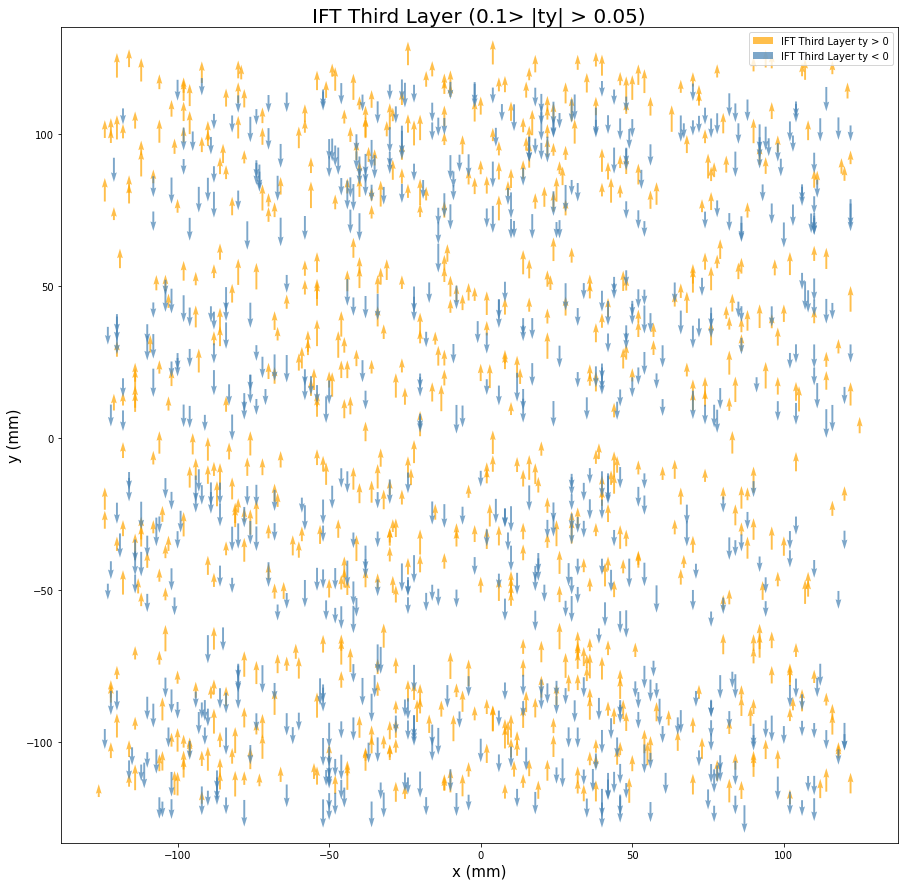

In [45]:
include_tx = False
vector_width, vector_scale = 0.0023, 3
def vector_plot(data, name, cut, color='blue', include_tx=include_tx, unit='mm'):  
    #plt.scatter(data['x'], data['y'], marker='.', alpha=0.7, label=f'{name}')
    pos = data[data['ty']>0]
    neg = data[data['ty']<0]
    if include_tx:
        plt.quiver(pos['x'], pos['y'], pos['tx'], pos['ty'], color='orange', alpha=0.7, width=vector_width, scale=vector_scale, label=f'{name} ty > 0')
        plt.quiver(neg['x'], neg['y'], neg['tx'], neg['ty'], color='steelblue', alpha=0.7, width=vector_width, scale=vector_scale, label=f'{name} ty < 0')
        #plt.quiver(data['x'], data['y'], data['tx'], data['ty'], color=color, alpha=0.7, width=vector_width, scale=vector_scale)
    else:
        plt.quiver(pos['x'], pos['y'], 0, pos['ty'], color='orange', alpha=0.7, width=vector_width, scale=vector_scale, label=f'{name} ty > 0')
        plt.quiver(neg['x'], neg['y'], 0, neg['ty'], color='steelblue', alpha=0.7, width=vector_width, scale=vector_scale, label=f'{name} ty < 0')
        #plt.quiver(data['x'], data['y'], 0, data['ty'], color=color, alpha=0.7, width=0.003, scale=14)
    plt.xlabel(f'x ({unit})', fontsize=15)
    plt.ylabel(f'y ({unit})', fontsize=15)
    plt.title(f'{name} ({cut[1]}> |ty| > {cut[0]})', fontsize=20)

plt.figure(figsize=(15, 15))  
vector_plot(ift_filter1, 'IFT First Layer', [0.05, 0.1], color='orange')
plt.figure(figsize=(15, 15))  
vector_plot(ift_filter2, 'IFT Second Layer', [0.05, 0.1], color='orange')
plt.figure(figsize=(15, 15))  
vector_plot(ift_filter3, 'IFT Third Layer', [0.05, 0.1], color='orange')

plt.legend()
plt.show()

### Angle correction

In [28]:
# Angle Correction in y-z coordinate
def AngleCorr_yz(tx, ty):
    # y/x = ty/tx, z/y = 1/ty
    theta = np.ones(len(tx))
    for i in tqdm(range(len(tx))):
        if tx[i] > 0:
            theta[i] = np.arctan(np.sqrt(ty[i]**2 +1) / tx[i] )
        elif tx[i] < 0:
            theta[i] = np.arctan(np.sqrt(ty[i]**2 +1) /tx[i] ) + np.pi
        elif tx[i] == 0 and np.sqrt(ty[i]**2 + 1) > 0:
            theta[i] = np.pi/2
        elif tx[i] == 0 and np.sqrt(ty[i]**2 + 1) == 0:
            print(f'At Event {i}, there occurs both tx & ty values are zero (tx:{tx[i]}, ty:{ty[i]})')
            theta[i] = np.nan
        else:
            print('occur error')
    phi = np.arctan(ty)
    return theta, phi
theta_emu, phi_emu = AngleCorr_yz(np.array(emulsion_20['tx']), np.array(emulsion_20['ty']))
theta_ift, phi_ift = AngleCorr_yz(np.array(ift_first_layer['tx']), np.array(ift_first_layer['ty']))

delta_phi = np.abs( np.nanmean(phi_emu) - np.mean(phi_ift) )
Delta_phi = delta_phi
xc, yc, zc = 70000, 50000, 0
def CoorShift_zy(x, y, tx_emu, ty_emu):
    z = np.zeros(len(x))
    theta_emu, phi_emu = AngleCorr_yz(tx_emu, ty_emu)

    z_new = (z-zc)*np.cos(Delta_phi) - (y-yc)*np.sin(Delta_phi) + zc
    y_new = (z-zc)*np.sin(Delta_phi) + (y-yc)*np.cos(Delta_phi) + yc

    tz_new = np.cos(phi_emu + Delta_phi) * np.sin(theta_emu)
    ty_new = np.sin(phi_emu + Delta_phi) * np.sin(theta_emu) / tz_new
    tx_new = np.cos(theta_emu) / tz_new

    dict = {'x': x, 'y': y_new, 'z': z_new, 'tx': tx_new, 'ty': ty_new, 'tz': tz_new}
    return pd.DataFrame(dict)
rot = CoorShift_zy(ak.Array(emulsion_20['x']), ak.Array(emulsion_20['y']), ak.Array(emulsion_20['tx']), ak.Array(emulsion_20['ty']))

100%|███████████████████████████████████████████████████████████████████████| 166390/166390 [00:09<00:00, 18011.47it/s]


#### tx vs y plot after angle correction

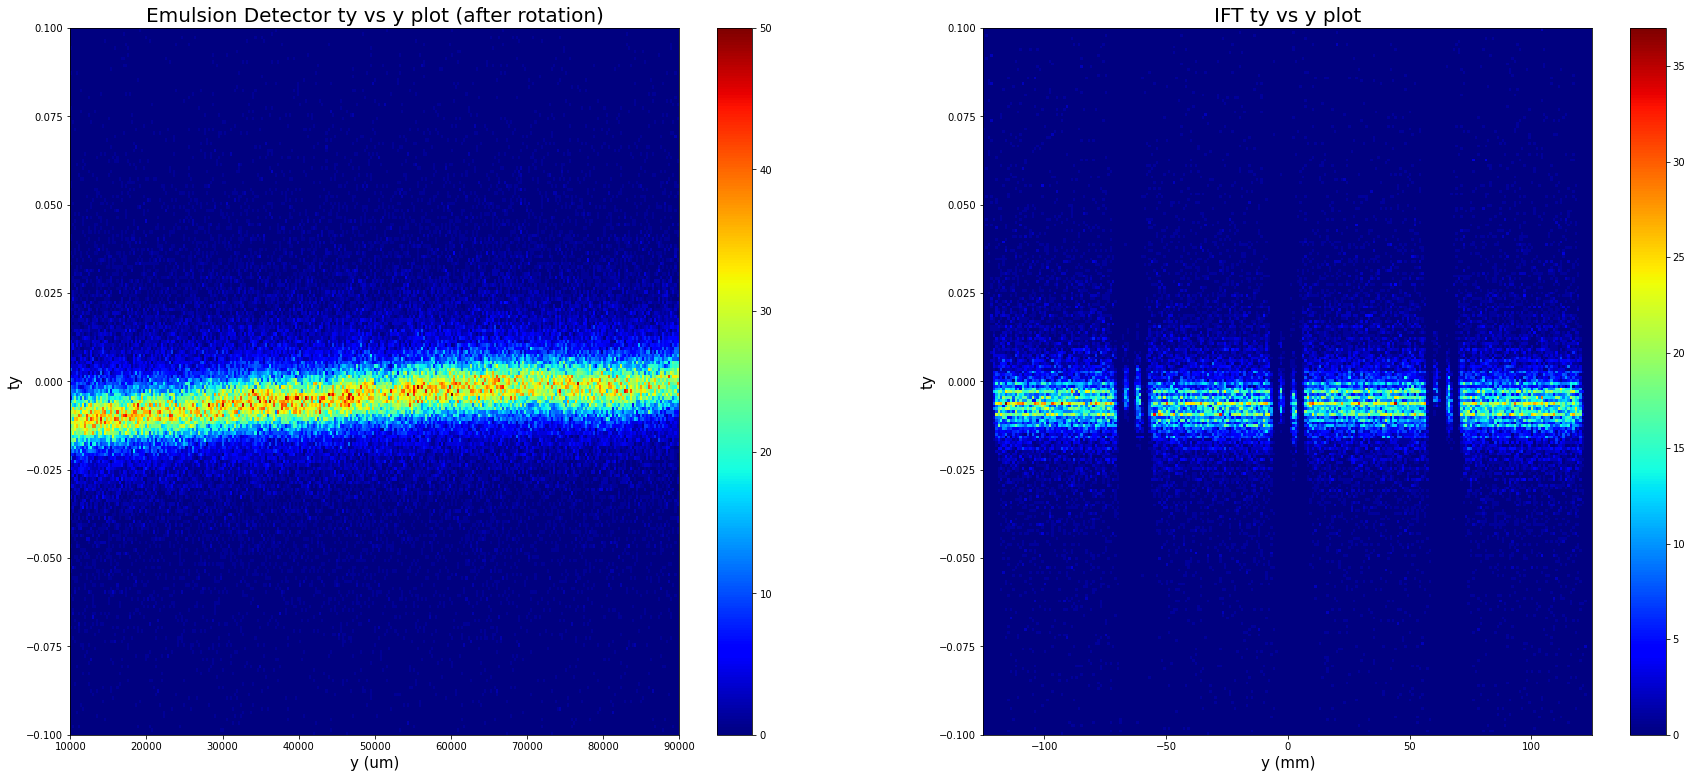

In [29]:
# ty vs y plot
plt.figure(figsize=(30, 13))

plt.subplot(1, 2, 1)


x_bin = np.linspace(10000, 90000, 301)
y_bin = np.linspace(-0.1, 0.1, 201)
plt.hist2d(rot['y'], rot['ty'], bins = [x_bin, y_bin], cmap=plt.cm.jet)
plt.title('Emulsion Detector ty vs y plot (after rotation)', fontsize=20)
plt.ylabel('ty', fontsize=15)
plt.xlabel('y (um)', fontsize=15)
plt.colorbar()
# ty vs y plot
plt.subplot(1, 2, 2)
x_bin = np.linspace(-125, 125, 251)
y_bin = np.linspace(-0.1, 0.1, 251)
plt.hist2d(ift_first_layer['y'], ift_first_layer['ty'], bins = [x_bin, y_bin], cmap=plt.cm.jet)
plt.title('IFT ty vs y plot', fontsize=20)
plt.ylabel('ty', fontsize=15)
plt.xlabel('y (mm)', fontsize=15)
plt.colorbar()

### Extrapolation

In [30]:
DistEmuIft = 55500

def Emu2Ift_Coor(x, y, tx, ty, mm=False, um=False, rotate=False):
    # Angle Rotation
    rot = CoorShift_zy(x, y, tx, ty)

    # Projection
    x_new = (DistEmuIft - np.array(rot['z'])) * np.array(rot['tx']) + x
    y_new = (DistEmuIft - np.array(rot['z'])) * np.array(rot['ty']) + np.array(rot['y'])

    # Transition
    x_ift_pred = x_new - 70000
    y_ift_pred = y_new - 60000

    if um:
        dict = {'x': x_ift_pred, 'y': y_ift_pred, 'tx': np.array(rot['tx']), 'ty': np.array(rot['ty']), 'tz': np.array(rot['tz'])}
        return pd.DataFrame(dict)
    elif mm:
        dict = {'x': x_ift_pred/1e3, 'y': y_ift_pred/1e3, 'tx': np.array(rot['tx']), 'ty': np.array(rot['ty']), 'tz': np.array(rot['tz'])}
        return pd.DataFrame(dict)

emu_pred = Emu2Ift_Coor(ak.Array(emulsion_20['x']), ak.Array(emulsion_20['y']), ak.Array(emulsion_20['tx']), ak.Array(emulsion_20['ty']), mm=True)

100%|███████████████████████████████████████████████████████████████████████| 166390/166390 [00:09<00:00, 16873.54it/s]


1.5824268285353686% data is selected after cut
1.5824268285353686% data is selected after cut
-55.987155620216946 65.87961600934231 -54.91253689654416 34.47041176537154


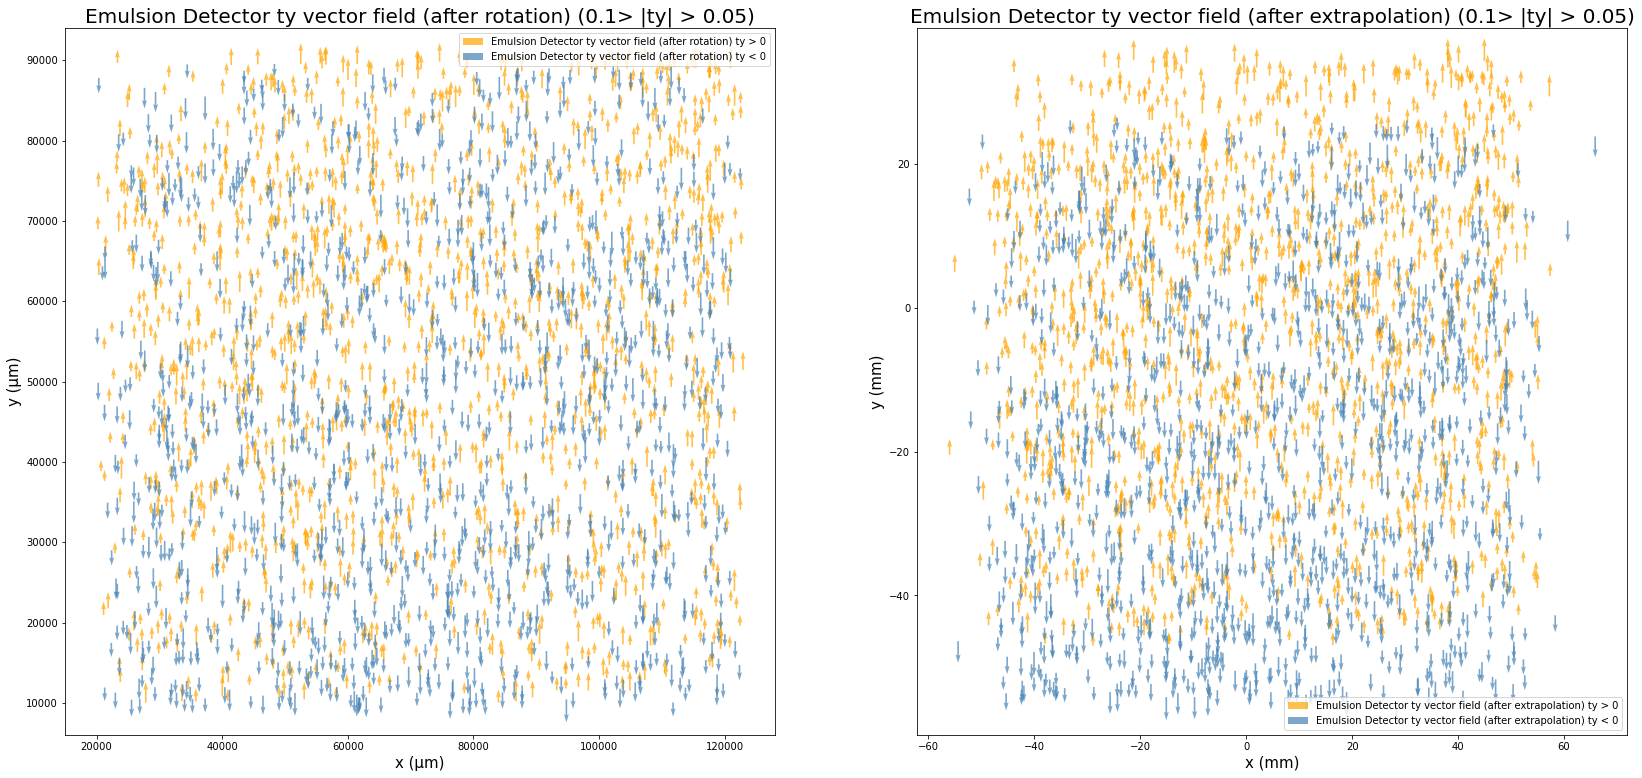

In [31]:
plt.figure(figsize=(28, 13))

plt.subplot(1, 2, 1)
rot_emu_filter = Filter(rot, ty_lower_cut=0.05, ty_upper_cut=0.1, upper=True)
vector_plot(rot_emu_filter, 'Emulsion Detector ty vector field (after rotation)', [0.05, 0.1], include_tx=False, unit='µm')

plt.legend()
plt.subplot(1, 2, 2)

emu_pred_filter = Filter(emu_pred, ty_lower_cut=0.05, ty_upper_cut=0.1, upper=True)
vector_plot(emu_pred_filter, 'Emulsion Detector ty vector field (after extrapolation)', [0.05, 0.1], include_tx=False, unit='mm')
print(min(emu_pred_filter['x']), max(emu_pred_filter['x']), min(emu_pred_filter['y']), max(emu_pred_filter['y']))
plt.legend()
plt.show()

1.5824268285353686% data is selected after cut
1.5824268285353686% data is selected after cut
-55.987155620216946 65.87961600934231 -54.91253689654416 34.47041176537154


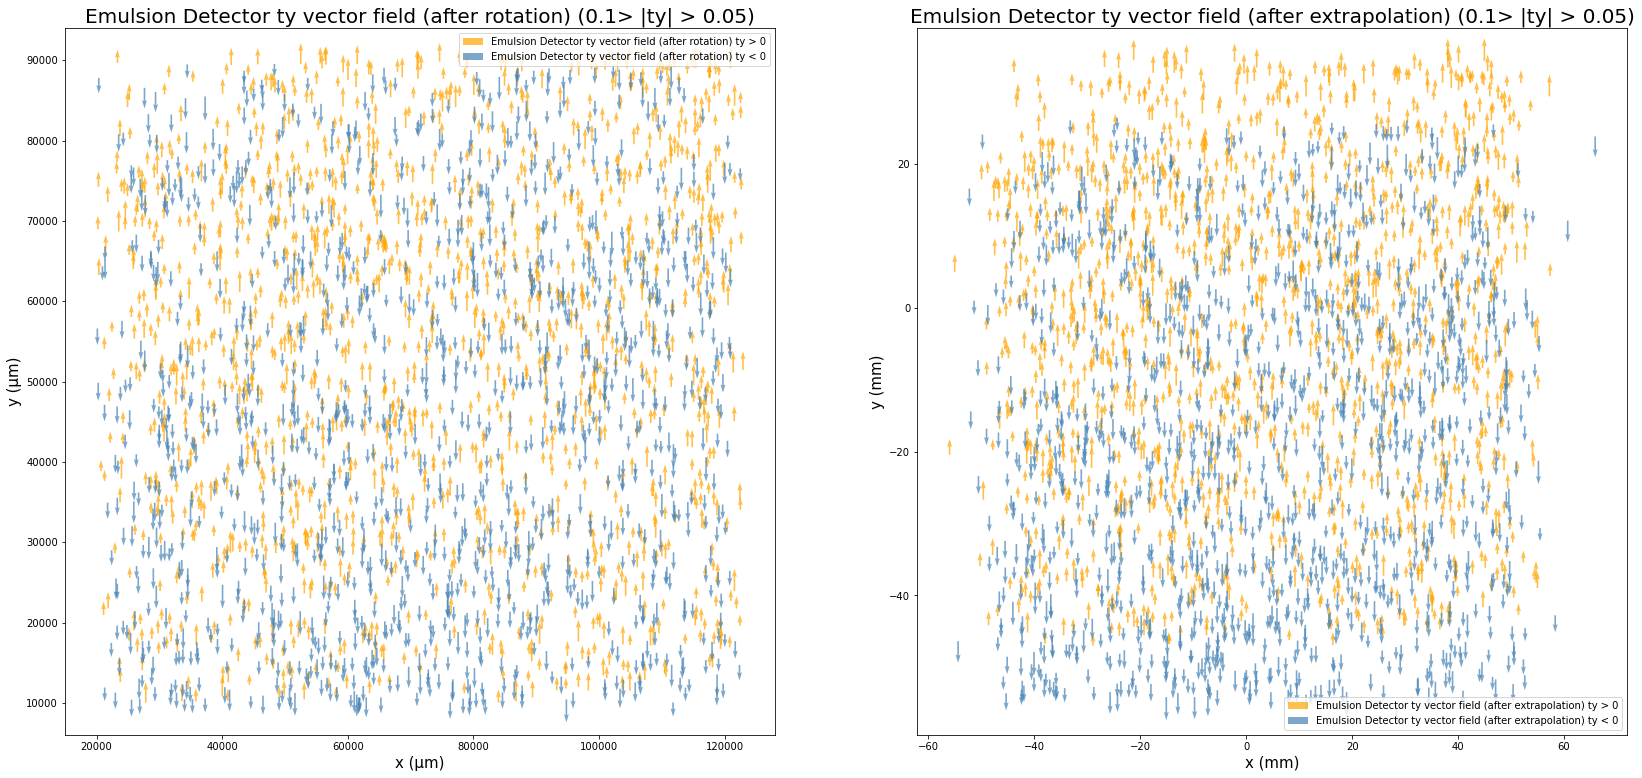

In [32]:
plt.figure(figsize=(28, 13))

plt.subplot(1, 2, 1)
rot_emu_filter = Filter(rot, ty_lower_cut=0.05, ty_upper_cut=0.1, upper=True)
vector_plot(rot_emu_filter, 'Emulsion Detector ty vector field (after rotation)', [0.05, 0.1], include_tx=False, unit='µm')

plt.legend()
plt.subplot(1, 2, 2)

emu_pred_filter = Filter(emu_pred, ty_lower_cut=0.05, ty_upper_cut=0.1, upper=True)
vector_plot(emu_pred_filter, 'Emulsion Detector ty vector field (after extrapolation)', [0.05, 0.1], include_tx=False, unit='mm')
print(min(emu_pred_filter['x']), max(emu_pred_filter['x']), min(emu_pred_filter['y']), max(emu_pred_filter['y']))
plt.legend()
plt.show()

### Window Selection Function

In [33]:
def win_selc(win_size_x, win_size_y, x_cen, y_cen, data, x_name='', y_name=''):
    xmin, xmax, ymin, ymax = (x_cen - win_size_x/2), (x_cen + win_size_x/2), (y_cen - win_size_y/2), (y_cen + win_size_y/2)

    win = data[data[x_name] >= xmin]
    win = win[win[x_name] <= xmax]
    win = win[win[y_name] >= ymin]
    win = win[win[y_name] <= ymax]
    
    return win

2.007136485280999% data is selected after cut
-49.99919891357422 -12.996732711791992 -48.89340591430664 -10.425711631774902


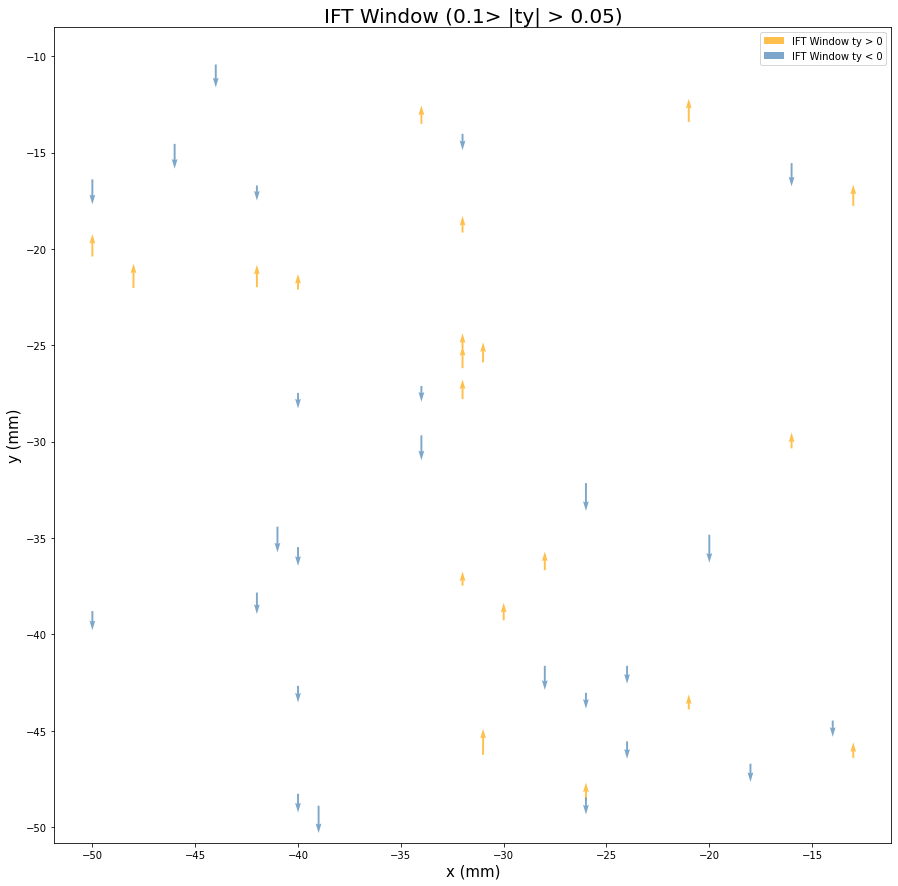

In [34]:
plt.figure(figsize=(15, 15))
ift_win = win_selc(40, 40, -30, -30, ift_first_layer, x_name='x', y_name='y')
ift_filter = Filter(ift_win, ty_lower_cut=0.05, ty_upper_cut=0.1, upper=True)
vector_plot(ift_filter, 'IFT Window', [0.05, 0.1], include_tx=False, unit='mm')
print(min(ift_filter['x']), max(ift_filter['x']), min(ift_filter['y']), max(ift_filter['y']))
plt.legend()
plt.show()

In [36]:
dx, dy = np.linspace(0, 40, 401).astype(np.float32), np.linspace(0, 45, 451).astype(np.float32)
import itertools

dxy = np.array(list(itertools.product(dx, dy))).astype(np.float32)

In [37]:

from scipy.spatial.distance import cdist

x_resol2, y_resol2 = np.mean(ift_first_layer['x error'])**2, np.mean(ift_first_layer['y error'])**2
emu = np.column_stack((emu_pred_filter['x']/(x_resol2), emu_pred_filter['y']/(y_resol2)))
total_chi2 = np.zeros([len(dx), len(dy)])
for i in tqdm(range(len(dx))):
    testiftx = ift_filter['x'] + dx[i] 
    for j in range(len(dy)):
        testifty = ift_filter['y'] + dy[j]

        testift = np.column_stack((testiftx/x_resol2, testifty/y_resol2))

        total_chi2[i, j] = np.sum(cdist(testift,emu).min(axis=1))
total_chi2

100%|████████████████████████████████████████████████████████████████████████████████| 401/401 [02:09<00:00,  3.10it/s]


array([[2468.09106747, 2734.72597438, 2683.09148715, ..., 2587.69882517,
        2846.68477368, 2725.93628985],
       [2465.3772314 , 2732.45656633, 2679.75516798, ..., 2585.05334529,
        2843.47511652, 2723.28047233],
       [2462.68355718, 2730.20085018, 2676.42952739, ..., 2582.42283312,
        2840.27854516, 2720.64659945],
       ...,
       [2161.64661634, 2338.3107976 , 1923.2468067 , ..., 2308.68320495,
        2011.12848474, 2164.31731526],
       [2161.17811049, 2337.92543036, 1923.81316794, ..., 2309.32784198,
        2010.65604357, 2163.43817506],
       [2160.72647888, 2337.55716311, 1924.40590456, ..., 2309.94356462,
        2010.20778565, 2162.57508977]])

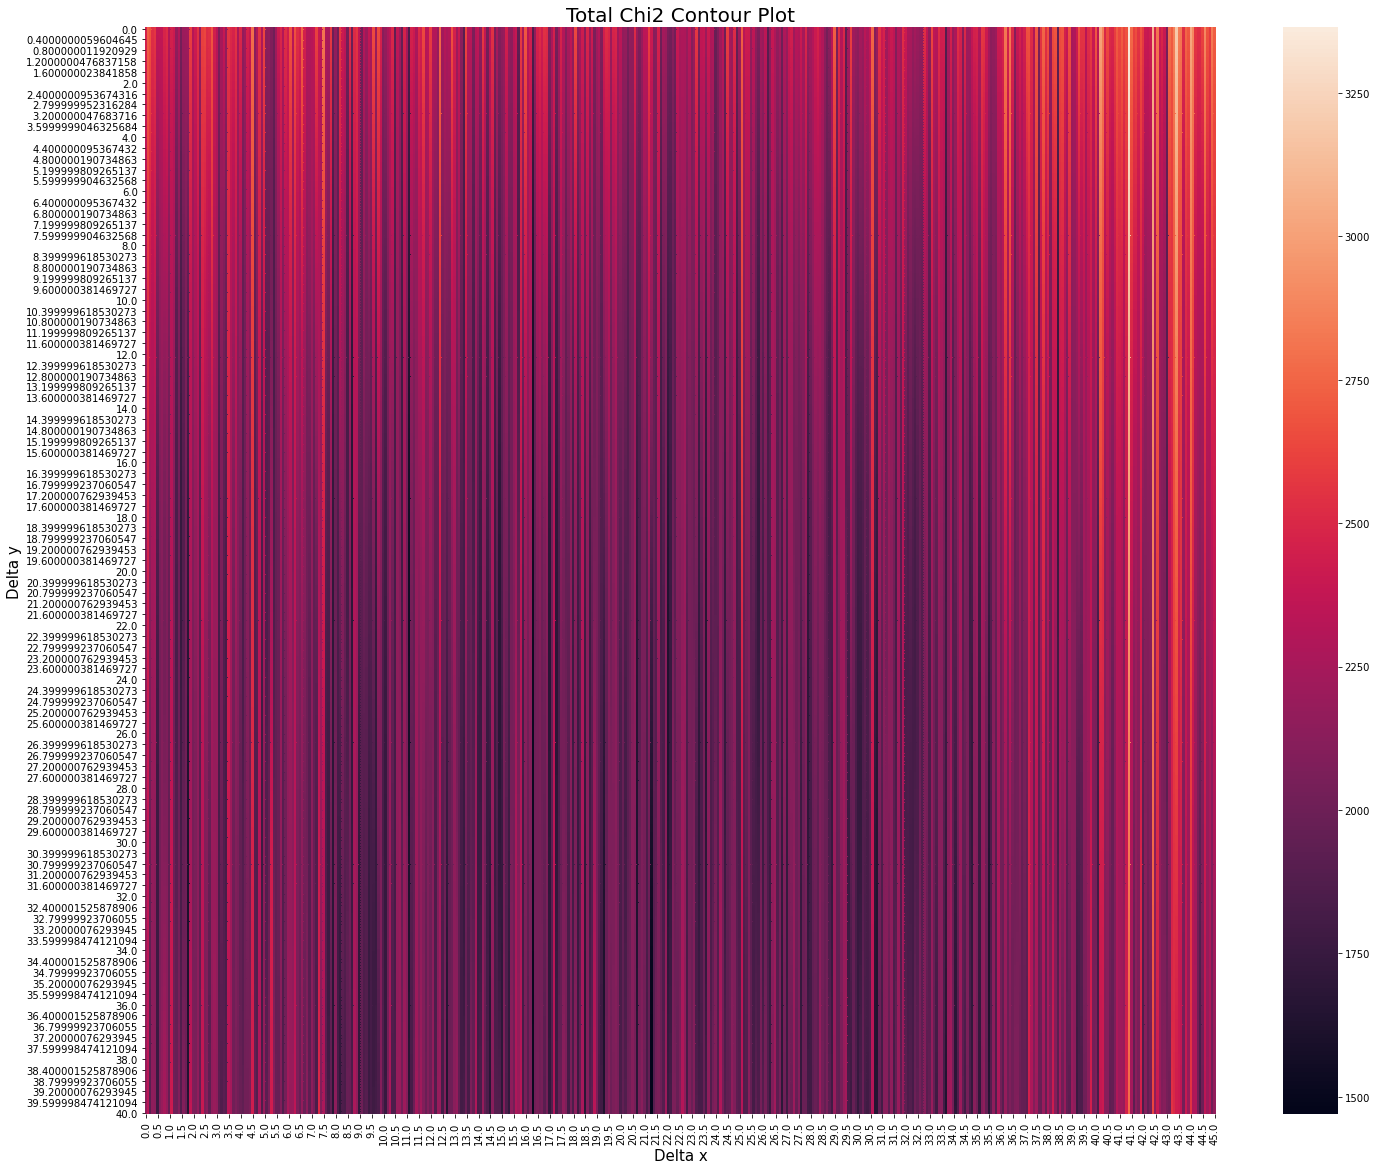

In [38]:
import seaborn as sns
plt.figure(figsize=(24, 20))
data = pd.DataFrame(total_chi2, columns=dy, index=dx)
sns.heatmap(data, annot=False)#, annot_kws={"size": 12})
plt.xlabel(r'Delta x', fontsize=15)
plt.ylabel(r'Delta y', fontsize=15)
plt.title('Total Chi2 Contour Plot', fontsize=20)
plt.show()

In [ ]:
--